# Overview of SwissLandStats

The `swisslandstats-geopy` provides an extended pandas-like interface to the [Swiss Federal Statistics Geodata](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata.html). In this notebook, we show how it can be used with the land use statistics as well as with the population and household statistics (STATPOP).

## Land use statistics

Let us first download and unzip the [land use statistics](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/land-use-cover-suitability/swiss-land-use-statistics.html) (note that the `make` command in the cell below will probably not work in Windows - in such case you might [click here](https://www.bfs.admin.ch/bfsstatic/dam/assets/6646411/master) to download the data manually).

In [ ]:
!make download_land

make: Nothing to be done for 'download_land'.


In [ ]:
import swisslandstats as sls

## IO and plotting

Now we can read the land statistics file from the Swiss Federal Statistical Office (SFSO) e.g., the Standard nomenclature NOAS04. It might take a while since there are over 2.7 million rows.

In [ ]:
ldf = sls.read_csv('data/land/AREA_NOAS04_17_181029.csv')

Then `ldf` will be a `LandDataFrame` object, which extends a pandas `DataFrame` with some methods aimed to process geographic raster data.

In [ ]:
ldf.head()

,E,N,X,Y,GMDE,FJ85,FJ97,FJ09,FJ18,AS85R_17,AS97R_17,AS09R_17,AS18_17,AS85R_4,AS97R_4,AS09R_4,AS18_4
RELI,,,,,,,,,,,,,,,,,
48551097,2485500,1109700,485500,109700,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551098,2485500,1109800,485500,109800,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551099,2485500,1109900,485500,109900,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551100,2485500,1110000,485500,110000,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551101,2485500,1110100,485500,110100,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3


Each row corresponds to a pixel, where `E`, `N` denote the coordinates of its centroid (in the [LV95 coordinate system](https://www.swisstopo.admin.ch/en/knowledge-facts/surveying-geodesy/reference-frames/local/lv95.html), or alternatively `X` and `Y` in [LV03](https://www.swisstopo.admin.ch/en/knowledge-facts/surveying-geodesy/reference-frames/local/lv03.html)).

The `FJ85`, `FJ97`, `FJ09` and `FJ18` denote the exact years when the observations for each of the four survey periods were taken. See [the datset description (link in French)](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie.html) for more information. The columns of the form *AS{survey_period}_{num_classes}* denote the land use/land cover class at its respective survey period. The free tier includes classifications for 17 and 4 land use/land cover classes.

Let us first plot a land use/land cover column, e.g., the land use/land cover [classified into the 4 main classes](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/nomenclature-standard.html) for the 2013/18 survey. We can use any colormap that works with matplotlib. In this example, we will use one that is well suited for the 4 main classes classification, which is included within the swisslandastats library:

<AxesSubplot:>

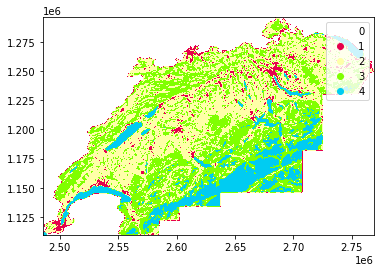

In [ ]:
ldf.plot('AS18_4', cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm, legend=True)

See the documentation for `LandDataFrame.plot` for more details.

On the other hand, we can use the `to_ndarray` method to transform any column to a numpy array:

In [ ]:
ldf.to_ndarray('AS18_4')

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 2, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 2, 2, ..., 0, 0, 0]], dtype=uint8)

Or also export any column to a GeoTiff file by means of the `to_geotiff` method, where the first argument corresponds to the output file path, and the second to the data column:

In [ ]:
ldf.to_geotiff('as18_4.tif', 'AS18_4')

## Basic transformations

We can operate over a `LandDataFrame` as we would do with any pandas `DataFrame`. For example, we can create a new column that represents the pixels that have been transformed from non-urban to urban during the 2004/09-2013/18 period:

In [ ]:
ldf['urban_09-18'] = (ldf['AS18_4'] == 1) & (ldf['AS09R_4'] != 1)

Let us plot the new column:

<AxesSubplot:>

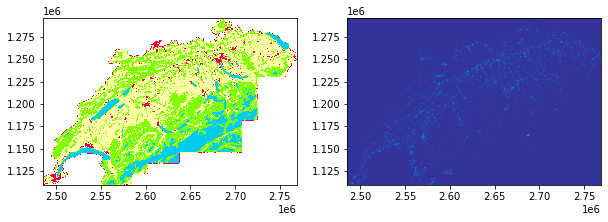

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ldf.plot('AS09R_4', cmap=sls.noas04_4_cmap, ax=axes[0])
ldf.plot('urban_09-18', ax=axes[1])

We might also subset our region by selecting a set of rows of interest:

<AxesSubplot:>

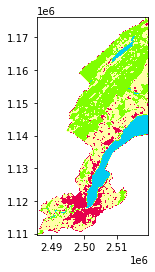

In [ ]:
ldf.iloc[:100000].plot('AS09R_4', cmap=sls.noas04_4_cmap)

## Geometric transformations

Selecting pixel rows is not the most natural way to extract geographic regions. Instead, we can clip a `LandDataFrame` instance to the extents of a given geometry. Note that .

Let us first use osmnx in order to obtain the bounds of a region of interest, e.g., the municipality of Lausanne:

In [ ]:
import osmnx as ox

geometry = ox.geocode_to_gdf('Lausanne, Vaud')['geometry'].iloc[0]

Now we can use the `clip_by_geometry` method in order to clip the `LandDataFrame` to the extents of such geometry. Just note that the [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system) of the geometry must be provided, otherwise, the one from the swisslandstats' `settings` module will be taken (i.e., [EPSG:2056](https://spatialreference.org/ref/epsg/2056) by default). Since the geometry of this example has been extracted from the OpenStreetMap, it will be in [EPSG:4326](https://spatialreference.org/ref/epsg/4326).

<AxesSubplot:>

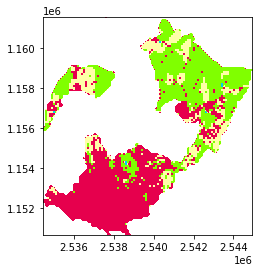

In [ ]:
subset_ldf = ldf.clip_by_geometry(geometry,
                                  geometry_crs=ox.settings.default_crs)
subset_ldf.plot('AS09R_4', cmap=sls.noas04_4_cmap)

Also note that clipping `LandDataFrame` instances by geometries might still be [due to the current implementation of geopandas](https://jorisvandenbossche.github.io/blog/2017/09/19/geopandas-cython/). Hopefully, [this will be resolved soon](https://github.com/geopandas/geopandas/issues/473) and we can expect significant speed-ups in such geometric operations.

In any case, the `clip_by_nominatim` method provides a shortcut for what has been done above:

<AxesSubplot:>

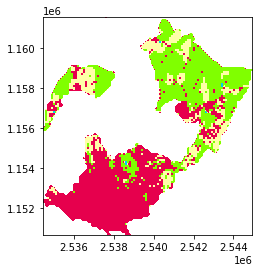

In [ ]:
same_subset_ldf = ldf.clip_by_nominatim('Lausanne, Vaud')
same_subset_ldf.plot('AS09R_4', cmap=sls.noas04_4_cmap)

## Population and household statistics: STATPOP

Let us now download and unzip the [population and household statistics](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/population-buildings-dwellings-persons/population-housholds-from-2010.html) (note that the `make` command in the cell below will probably not work in Windows - in such case you might [click here](https://www.bfs.admin.ch/bfsstatic/dam/assets/9947069/master) to download the data manually).

In [ ]:
!make download_statpop

make: Nothing to be done for 'download_statpop'.


In the STATPOP dataset, the `x` and `y` coordinates in the [EPSG:2056](https://spatialreference.org/ref/epsg/2056) CRS are stored in the `E_KOORD` and `N_KOORD` columns respectively (instead of `E` and `N` in the land use statistics). Therefore, we need to provide such information to the `read_csv` method as in: 

In [ ]:
statpop_ldf = sls.read_csv('data/statpop/STATPOP2018.csv', x_column='E_KOORD',
                           y_column='N_KOORD')
statpop_ldf.head()

,X_KOORD,Y_KOORD,E_KOORD,N_KOORD,B18BTOT,B18B11,B18B12,B18B13,B18B14,B18B15,...,B18B55,B18B56,H18PTOT,H18P01,H18P02,H18P03,H18P04,H18P05,H18P06,H18PI
RELI,,,,,,,,,,,,,,,,,,,,,
48671121,486700,112100,2486700,1112100,33,28,5,4,3,0,...,0,0,6,0,3,3,3,3,3,2
48641119,486400,111900,2486400,1111900,10,10,0,0,0,0,...,0,0,4,3,3,3,3,0,0,1
48651118,486500,111800,2486500,1111800,17,14,3,3,0,0,...,0,0,5,3,3,0,3,0,3,1
48681119,486800,111900,2486800,1111900,167,125,42,26,3,15,...,3,0,47,4,10,10,12,6,5,1
48721131,487200,113100,2487200,1113100,16,14,3,3,0,3,...,0,0,5,3,3,3,0,0,3,1


Let us focus on the Canton of Vaud only:

In [ ]:
statpop_ldf = statpop_ldf.clip_by_nominatim('Vaud, Switzerland')

Among other information, STATPOP provides a set of columns with the permanent resident population by age group and sex. These are of the form 'B{jj}B{sex}{age_group}', where 'jj' corresponds to the year (in this example, we have '18' for 2018), 'sex' can be either 'M' (man) or 'W' (woman), and 'age_group' is a two-digit integer (zero-padded when necessary) that represents a 5-year age range from '01' (under 4 years old) to '19' (90 and older).

Let us plot the male population in the 65-69 age range, i.e., 'B18BM14':

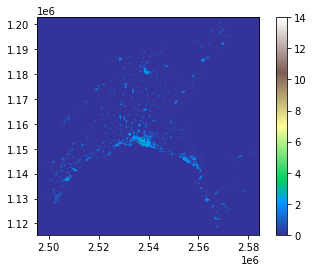

In [ ]:
ax = statpop_ldf.plot('B18BM14')
plt.colorbar(ax.get_images()[0])

We can perform any kind of pandas-like operation in our `statpop_ldf` instance. For example, let us compute the total population considered most "vulnerable" to urban heat exposure, e.g., ages under 14 and over 60 for both sexes:

In [ ]:
vulnerable_columns = [
    f'B18B{sex}{age_group:02}' for sex in ['M', 'W']
    for age_group in list(range(1, 4)) + list(range(13, 20))
]
statpop_ldf['vulnerable'] = statpop_ldf[vulnerable_columns].sum(axis=1)

We can now plot this information as we would with any other column:

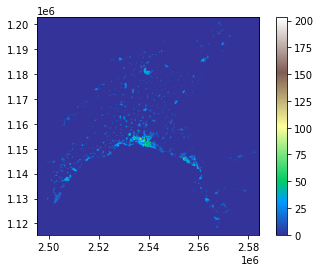

In [ ]:
ax = statpop_ldf.plot('vulnerable')
plt.colorbar(ax.get_images()[0])